In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
%load_ext google.cloud.bigquery
from google.cloud import bigquery

client=bigquery.Client()
project_id = "som-nero-phi-jonc101"

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [6]:
import json
import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, classification_report

In [23]:
import json, time, os, hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, ParameterGrid, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score 
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, classification_report, confusion_matrix

In [8]:
# load data
table_id_all_features_imputed_train= f"{project_id}.blood_culture_stewardship_sandy_2024.final_base_features_imputed_train_dedup"
table_id_all_features_imputed_val= f"{project_id}.blood_culture_stewardship_sandy_2024.final_base_features_imputed_val_dedup"
table_id_all_features_imputed_test= f"{project_id}.blood_culture_stewardship_sandy_2024.final_base_features_imputed_test_dedup"
train_imp = client.query(f"SELECT * FROM `{table_id_all_features_imputed_train}`").to_dataframe()
val_imp = client.query(f"SELECT * FROM `{table_id_all_features_imputed_val}`").to_dataframe()
test_imp = client.query(f"SELECT * FROM `{table_id_all_features_imputed_test}`").to_dataframe()


In [10]:
train_imp["positive_blood_culture"].mean()

np.float64(0.08026651043015001)

In [26]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import sklearn

# --- define your keys (from your message) ---
label_key = "positive_blood_culture"



# vital_feature_key = [
#     "temp_min_c", "temp_avg_c", "temp_max_c", "temp_median_c", "temp_mode_c",
#     "resp_min", "resp_avg", "resp_max", "resp_median", "resp_mode",
#     "hr_min", "hr_avg", "hr_max", "hr_median", "hr_mode",
#     "sysbp_min", "sysbp_avg", "sysbp_max", "sysbp_median", "sysbp_mode",
#     "diabp_min", "diabp_avg", "diabp_max", "diabp_median", "diabp_mode",
#     "spo2_min", "spo2_avg", "spo2_max", "spo2_median", "spo2_mode"
# ]
demo_feature_key = ["gender", "age", "bmi", "adi_score"]

vital_feature_key = [
    "temp_max_c", 
    "resp_max", 
    "hr_max",
    # "sysbp_min", 
    "diabp_min",
    # "spo2_min", 
]

lab_ua_lda_feature_key = [
    "max_wbc", "max_neutrophils", "max_anc", "min_lymphocytes", "min_alc",
    "min_hgb", "min_plt", "max_glucose", "max_lactate",
    # "Leukocyte_Esterase", "WBC_urine", "Bacteria_urine","Nitrite_urine", 
    "has_any_line"
]

# --- define your categorical columns (no has_any_line here) ---
cat_cols_user = [
    "Leukocyte_Esterase", "WBC_urine", "Bacteria_urine", "Nitrite_urine",
    "gender"
]

# --- define binary passthrough cols ---
binary_cols_user = ["has_any_line"]

# 1) Build final feature list (keep only columns that exist in train_imp)
selected_features = [c for c in (demo_feature_key + vital_feature_key + lab_ua_lda_feature_key)
                     if c in train_imp.columns]

# Categorical columns present
cat_cols = [c for c in cat_cols_user if c in selected_features]

# Binary passthrough columns present
binary_cols = [c for c in binary_cols_user if c in selected_features]

# Numeric = selected_features \ (categorical + binary)
num_cols = [c for c in selected_features
            if c not in cat_cols + binary_cols
            and pd.api.types.is_numeric_dtype(train_imp[c])]

# Safety: ensure no NaNs remain in model inputs
for df_name, df in [("train_imp", train_imp), ("val_imp", val_imp), ("test_imp", test_imp)]:
    missing_count = df[selected_features].isna().sum().sum()
    if missing_count > 0:
        raise ValueError(f"{df_name} still has {missing_count} missing values in selected features. "
                         "Double-check imputation steps.")

# Version-safe OneHotEncoder kwargs (sklearn 1.2+ uses sparse_output)
ohe_kwargs = dict(handle_unknown="ignore", dtype=np.float32)
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

# 2) Build ColumnTransformer (fit on TRAIN only)
ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(**ohe_kwargs), cat_cols),
        ("bin", "passthrough", binary_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=True,
)

X_train_base = train_imp[selected_features]
X_val_base   = val_imp[selected_features]
X_test_base  = test_imp[selected_features]

y_train = train_imp[label_key].astype(int).values
y_val   = val_imp[label_key].astype(int).values
y_test  = test_imp[label_key].astype(int).values

ct.fit(X_train_base)  # train-only fit (no leakage)

def transform_to_df(ct, X, index):
    X_mat = ct.transform(X)
    cols = ct.get_feature_names_out()
    return pd.DataFrame(X_mat, columns=cols, index=index)

X_train = transform_to_df(ct, X_train_base, X_train_base.index)
X_val   = transform_to_df(ct, X_val_base,   X_val_base.index)
X_test  = transform_to_df(ct, X_test_base,  X_test_base.index)


print("✅ Shapes:")
print("   X_train:", X_train.shape, " | y_train:", y_train.shape)
print("   X_val  :", X_val.shape,   " | y_val  :", y_val.shape)
print("   X_test :", X_test.shape,  " | y_test :", y_test.shape)
print("Example features:", list(X_train.columns[:12]))


✅ Shapes:
   X_train: (73393, 20)  | y_train: (73393,)
   X_val  : (13441, 20)  | y_val  : (13441,)
   X_test : (15181, 20)  | y_test : (15181,)
Example features: ['num__age', 'num__bmi', 'num__adi_score', 'num__temp_max_c', 'num__resp_max', 'num__hr_max', 'num__diabp_min', 'num__max_wbc', 'num__max_neutrophils', 'num__max_anc', 'num__min_lymphocytes', 'num__min_alc']


In [34]:
# new flag feature engieering 
# import numpy as np
# import pandas as pd
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

# label_key = "positive_blood_culture"

# # your original selected subsets
# demo_feature_key = ["gender", "age", "bmi", "adi_score"]
# vital_feature_key = [
#     "temp_max_c",
#     "resp_max",
#     "hr_max",
#     "sysbp_min",
#     "diabp_min",
#     "spo2_min",
# ]
# lab_ua_lda_feature_key = [
#     "max_wbc", "max_neutrophils", "max_anc", "min_lymphocytes", "min_alc",
#     "min_hgb", "min_plt", "max_glucose", "max_lactate",
#     "Leukocyte_Esterase", "WBC_urine", "Bacteria_urine",
#     "Nitrite_urine", "has_any_line"
# ]
# cat_cols_user = [
#     "Leukocyte_Esterase", "WBC_urine", "Bacteria_urine", "Nitrite_urine",
#     "gender"
# ]
# binary_cols_user = ["has_any_line"]


# # ==========================================================
# # 1) safe feature engineering (no NaNs from division)
# # ==========================================================
# def add_clinical_features(df: pd.DataFrame) -> pd.DataFrame:
#     df = df.copy()

#     # helper to avoid KeyErrors if a col is missing
#     def g(col, default=np.nan):
#         return df[col] if col in df.columns else pd.Series(default, index=df.index)

#     # --- threshold flags (these shouldn't make NaNs) ---
#     df["flag_temp_high"]   = (g("temp_max_c") >= 38).astype(float)
#     df["flag_temp_low"]    = (g("temp_max_c") <= 36).astype(float)
#     df["flag_hr_high"]     = (g("hr_max") >= 100).astype(float)
#     df["flag_resp_high"]   = (g("resp_max") >= 22).astype(float)
#     df["flag_hypotension"] = (g("sysbp_min") <= 90).astype(float)
#     df["flag_spo2_low"]    = (g("spo2_min") < 94).astype(float)

#     df["flag_lactate_high"] = (g("max_lactate") > 2).astype(float)
#     df["flag_wbc_high"]     = (g("max_wbc") > 11).astype(float)
#     df["flag_wbc_low"]      = (g("max_wbc") < 4).astype(float)

#     # --- ratios / interactions ---
#     # replace 0 denominator with 1 to avoid NaN; you can pick another small constant
#     sysbp = g("sysbp_min").replace(0, 1)
#     df["shock_index"] = g("hr_max") / sysbp

#     lymph = g("min_lymphocytes").replace(0, 1)
#     df["nlr"] = g("max_neutrophils") / lymph

#     alc = g("min_alc").replace(0, 1)
#     df["alr"] = g("max_anc") / alc

#     df["temp_wbc_interaction"] = g("temp_max_c").fillna(0) * g("max_wbc").fillna(0)

#     # clip extremes
#     df["shock_index"] = df["shock_index"].clip(0, 5)
#     df["nlr"] = df["nlr"].clip(0, 50)
#     df["alr"] = df["alr"].clip(0, 50)

#     # --- composite counts ---
#     vital_flags = [
#         "flag_temp_high", "flag_temp_low", "flag_hr_high",
#         "flag_resp_high", "flag_hypotension", "flag_spo2_low"
#     ]
#     lab_flags = ["flag_lactate_high", "flag_wbc_high", "flag_wbc_low"]

#     df["n_abnormal_vitals"] = df[vital_flags].fillna(0).sum(axis=1)
#     df["n_abnormal_labs"]   = df[lab_flags].fillna(0).sum(axis=1)

#     df["flag_septic_pattern"] = (
#         (
#             (df["flag_temp_high"] * df["flag_hr_high"]) +
#             (df["flag_temp_high"] * df["flag_lactate_high"]) +
#             (df["flag_hypotension"] * df["flag_lactate_high"])
#         ) > 0
#     ).astype(float)

#     # finally, ensure *engineered* cols have no NaN
#     engineered_cols = (
#         vital_flags
#         + lab_flags
#         + [
#             "shock_index", "nlr", "alr", "temp_wbc_interaction",
#             "n_abnormal_vitals", "n_abnormal_labs",
#             "flag_septic_pattern",
#         ]
#     )
#     df[engineered_cols] = df[engineered_cols].fillna(0.0)

#     return df


# # apply on top of your already-imputed data
# train_imp = add_clinical_features(train_imp)
# val_imp   = add_clinical_features(val_imp)
# test_imp  = add_clinical_features(test_imp)


# # ==========================================================
# # 2) build feature lists that ACTUALLY exist
# # ==========================================================
# base_features = (
#     demo_feature_key
#     + vital_feature_key
#     + lab_ua_lda_feature_key
# )
# base_features = [c for c in base_features if c in train_imp.columns]

# engineered_binary_cols = [
#     "flag_temp_high", "flag_temp_low", "flag_hr_high", "flag_resp_high",
#     "flag_hypotension", "flag_spo2_low",
#     "flag_lactate_high", "flag_wbc_high", "flag_wbc_low",
#     "flag_septic_pattern",
# ]
# engineered_numeric_cols = [
#     "shock_index", "nlr", "alr",
#     "temp_wbc_interaction",
#     "n_abnormal_vitals", "n_abnormal_labs",
# ]
# engineered_binary_cols = [c for c in engineered_binary_cols if c in train_imp.columns]
# engineered_numeric_cols = [c for c in engineered_numeric_cols if c in train_imp.columns]

# selected_features = base_features + engineered_binary_cols + engineered_numeric_cols

# # cats present
# cat_cols = [c for c in cat_cols_user if c in selected_features]
# # original binary + engineered binary
# binary_cols = [c for c in binary_cols_user if c in selected_features] + engineered_binary_cols
# # numeric = the rest
# num_cols = [
#     c for c in selected_features
#     if c not in cat_cols + binary_cols
#     and pd.api.types.is_numeric_dtype(train_imp[c])
# ]

# # ==========================================================
# # 3) safety check (should pass now)
# # ==========================================================
# for df_name, df in [("train_imp", train_imp), ("val_imp", val_imp), ("test_imp", test_imp)]:
#     mc = df[selected_features].isna().sum().sum()
#     if mc > 0:
#         # if this still hits, print which columns:
#         print(df[selected_features].isna().sum().sort_values(ascending=False).head(20))
#         raise ValueError(f"{df_name} still has {mc} missing values after feature engineering.")

# # ==========================================================
# # 4) ColumnTransformer as before
# # ==========================================================
# ohe_kwargs = dict(handle_unknown="ignore", dtype=np.float32)
# from sklearn.preprocessing import OneHotEncoder
# if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
#     ohe_kwargs["sparse_output"] = False
# else:
#     ohe_kwargs["sparse"] = False

# ct = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_cols),
#         ("cat", OneHotEncoder(**ohe_kwargs), cat_cols),
#         ("bin", "passthrough", binary_cols),
#     ],
#     remainder="drop",
#     verbose_feature_names_out=True,
# )

# X_train_base = train_imp[selected_features]
# X_val_base   = val_imp[selected_features]
# X_test_base  = test_imp[selected_features]

# y_train = train_imp[label_key].astype(int).values
# y_val   = val_imp[label_key].astype(int).values
# y_test  = test_imp[label_key].astype(int).values

# ct.fit(X_train_base)

# def transform_to_df(ct, X, index):
#     X_mat = ct.transform(X)
#     cols = ct.get_feature_names_out()
#     return pd.DataFrame(X_mat, columns=cols, index=index)

# X_train = transform_to_df(ct, X_train_base, X_train_base.index)
# X_val   = transform_to_df(ct, X_val_base,   X_val_base.index)
# X_test  = transform_to_df(ct, X_test_base,  X_test_base.index)

# print("✅ Shapes:")
# print("   X_train:", X_train.shape, " | y_train:", y_train.shape)
# print("   X_val  :", X_val.shape,   " | y_val  :", y_val.shape)
# print("   X_test :", X_test.shape,  " | y_test :", y_test.shape)


In [35]:
import json, time, os, hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, ParameterGrid, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score 
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, classification_report, confusion_matrix

# ---------- config ----------
results_path = "logreg_grid_results_selected_subset_features_new_label.parquet"   # where partial results are saved
best_model_path = "logreg_best_model_selected_subset_features_new_labels.pkl"      # final model after search
random_state = 42
n_splits = 5
max_iter = 2000
tol = 1e-4
scoring = {"pr_auc": "average_precision", "roc_auc": "roc_auc"}

# Your parameter grid (feel free to trim/expand)
param_grid = [
    {"penalty": ["l1"], "solver": ["liblinear", "saga"],
     "C": [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
     "class_weight": [None, "balanced", {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}]},
    {"penalty": ["l2"], "solver": ["liblinear", "saga", "lbfgs", "sag"],
     "C": [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
     "class_weight": [None, "balanced", {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}]},
]

# ---------- helpers ----------
def params_fingerprint(params: dict) -> str:
    """Stable hash so we can identify completed combos even if dict order changes."""
    s = json.dumps(params, sort_keys=True)
    return hashlib.md5(s.encode()).hexdigest()

def load_results(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        return pd.read_parquet(path)
    cols = ["fp", "params_json", "penalty", "solver", "C", "class_weight",
            "cv_splits", "fit_time_sec",
            "pr_auc_mean", "pr_auc_std", "roc_auc_mean", "roc_auc_std"]
    return pd.DataFrame(columns=cols)

def append_result(df: pd.DataFrame, row: dict, path: str):
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    df.to_parquet(path, index=False)
    return df

# ---------- load previous results if any ----------
results_df = load_results(results_path)
done = set(results_df["fp"]) if len(results_df) else set()

grid = list(ParameterGrid(param_grid))
print(f"Total combos in grid: {len(grid)} | already done: {len(done)} | remaining: {len(grid) - len(done)}")

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# ---------- main loop (safe to interrupt & resume) ----------
for i, params in enumerate(grid, start=1):
    fp = params_fingerprint(params)
    if fp in done:
        # skip completed combo
        continue

    # Some solvers don’t support some penalties → catch & record failure gracefully
    try:
        lr = LogisticRegression(
            **params,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state,
        )
        t0 = time.time()
        cv_res = cross_validate(
            lr, X_train, y_train,
            scoring=scoring, cv=cv, n_jobs=-1, error_score=np.nan, return_train_score=False
        )
        t1 = time.time()

        row = {
            "fp": fp,
            "params_json": json.dumps(params, sort_keys=True),
            "penalty": params["penalty"],
            "solver": params["solver"],
            "C": params["C"],
            "class_weight": str(params["class_weight"]),
            "cv_splits": n_splits,
            "fit_time_sec": round(t1 - t0, 3),
            "pr_auc_mean": float(np.nanmean(cv_res["test_pr_auc"])),
            "pr_auc_std": float(np.nanstd(cv_res["test_pr_auc"])),
            "roc_auc_mean": float(np.nanmean(cv_res["test_roc_auc"])),
            "roc_auc_std": float(np.nanstd(cv_res["test_roc_auc"])),
        }
        results_df = append_result(results_df, row, results_path)
        done.add(fp)
        print(f"[{len(done)}/{len(grid)}] {params} | PR-AUC={row['pr_auc_mean']:.4f} | time={row['fit_time_sec']}s")

    except Exception as e:
        # log the failure and continue
        row = {
            "fp": fp,
            "params_json": json.dumps(params, sort_keys=True),
            "penalty": params.get("penalty"),
            "solver": params.get("solver"),
            "C": params.get("C"),
            "class_weight": str(params.get("class_weight")),
            "cv_splits": n_splits,
            "fit_time_sec": np.nan,
            "pr_auc_mean": np.nan,
            "pr_auc_std": np.nan,
            "roc_auc_mean": np.nan,
            "roc_auc_std": np.nan,
        }
        results_df = append_result(results_df, row, results_path)
        done.add(fp)
        print(f"[{len(done)}/{len(grid)}] FAILED {params} -> {e}")

# ---------- pick best, refit on full TRAIN, evaluate on VAL/TEST ----------
if len(results_df):
    best_row = results_df.sort_values("pr_auc_mean", ascending=False).iloc[0]
    best_params = json.loads(best_row["params_json"])
    print("\nBest by CV PR-AUC:", best_params, f"PR-AUC={best_row['pr_auc_mean']:.4f}")

    # Refit best on all TRAIN
    best_lr = LogisticRegression(**best_params, max_iter=max_iter, tol=tol, random_state=random_state)
    best_lr.fit(X_train, y_train)

    # Evaluate on VAL / TEST
    from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, classification_report, confusion_matrix

    val_proba = best_lr.predict_proba(X_val)[:,1]
    test_proba = best_lr.predict_proba(X_test)[:,1]

    print(f"[VAL] ROC AUC={roc_auc_score(y_val, val_proba):.4f} | PR AUC={average_precision_score(y_val, val_proba):.4f}")
    print(f"[TEST] ROC AUC={roc_auc_score(y_test, test_proba):.4f} | PR AUC={average_precision_score(y_test, test_proba):.4f}")

    # Pick a threshold on VAL (max F1), then report
    prec, rec, thr = precision_recall_curve(y_val, val_proba)
    f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
    t_star = float(thr[np.nanargmax(f1s)])
    val_pred  = (val_proba  >= t_star).astype(int)
    test_pred = (test_proba >= t_star).astype(int)
    print(f"Chosen threshold (VAL, max F1): {t_star:.4f}")
    print("[VAL]  report:\n", classification_report(y_val,  val_pred,  digits=3))
    print("[TEST] report:\n", classification_report(y_test, test_pred, digits=3))

    # Save model
    import joblib
    joblib.dump(best_lr, best_model_path)
    print(f"Saved best model to: {best_model_path}")
else:
    print("No results collected.")

Total combos in grid: 300 | already done: 0 | remaining: 300


/var/folders/d1/3gdyy98d6h1d9pxx47s40vv40000gp/T/ipykernel_35724/4257631843.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[1/300] {'C': 0.0005, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.1424 | time=9.504s
[2/300] {'C': 0.0005, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.1466 | time=9.152s
[3/300] {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.1888 | time=3.669s
[4/300] {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.1888 | time=1.853s
[5/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.1779 | time=4.397s
[6/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.1669 | time=7.549s
[7/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.1886 | time=2.032s
[8/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.1894 | time=8.233s
[9/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 5}, 'penalty': '

KeyboardInterrupt: 

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
import numpy as np, pandas as pd, time

TARGET_RECALL = 0.95
random_state = 42
n_splits = 3

def threshold_at_recall(y_true, y_score, target_recall=0.95):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    idx = np.where(rec[:-1] >= target_recall)[0]
    return float(np.max(thr[idx])) if len(idx) else None

def fold_metrics_at_rec95(clf, X, y, n_splits=3, seed=42):
    X_arr = np.asarray(X)
    y_arr = np.asarray(y).ravel()
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    precisions, thresholds, prs, rocs = [], [], [], []
    for tr, va in cv.split(X_arr, y_arr):
        clf.fit(X_arr[tr], y_arr[tr])
        proba = clf.predict_proba(X_arr[va])[:,1]
        prs.append(average_precision_score(y_arr[va], proba))
        rocs.append(roc_auc_score(y_arr[va], proba))
        t_star = threshold_at_recall(y_arr[va], proba, TARGET_RECALL)
        if t_star is None:
            precisions.append(0.0)
            thresholds.append(np.nan)
        else:
            pred = (proba >= t_star).astype(int)
            tp = np.sum((pred==1)&(y_arr[va]==1))
            fp = np.sum((pred==1)&(y_arr[va]==0))
            precisions.append(tp/max(tp+fp,1))
            thresholds.append(t_star)
    return {
        "cv_pr_auc_mean": float(np.mean(prs)),
        "cv_roc_auc_mean": float(np.mean(rocs)),
        "prec_at_rec95_mean": float(np.mean(precisions)),
        "prec_at_rec95_std": float(np.std(precisions)),
        "thr_rec95_median": float(np.nanmedian(thresholds)),
        "thr_rec95_iqr": float(np.nanpercentile(thresholds,75)-np.nanpercentile(thresholds,25)),
    }

# ====== small quick grid ======
quick_xgb_specs = [
    # Baseline shallow tree
    {"max_depth":3, "eta":0.1, "subsample":0.8, "colsample_bytree":0.8, "scale_pos_weight":8, "n_estimators":200},
    # Deeper trees
    {"max_depth":4, "eta":0.1, "subsample":0.8, "colsample_bytree":0.8, "scale_pos_weight":8, "n_estimators":300},
    # Slightly slower learning rate
    {"max_depth":3, "eta":0.05, "subsample":0.8, "colsample_bytree":0.8, "scale_pos_weight":8, "n_estimators":400},
    # Higher imbalance compensation
    {"max_depth":3, "eta":0.1, "subsample":0.8, "colsample_bytree":0.8, "scale_pos_weight":12, "n_estimators":300},
    {"max_depth":4, "eta":0.05, "subsample":0.8, "colsample_bytree":0.8, "scale_pos_weight":12, "n_estimators":400},
    # More aggressive boosting
    {"max_depth":5, "eta":0.1, "subsample":0.9, "colsample_bytree":0.9, "scale_pos_weight":10, "n_estimators":400},
    # Regularized smaller model
    {"max_depth":3, "eta":0.1, "subsample":0.7, "colsample_bytree":0.7, "scale_pos_weight":8, "n_estimators":200,
     "reg_lambda":2.0, "reg_alpha":0.5},
]

rows=[]
for spec in quick_xgb_specs:
    xgb = XGBClassifier(
        use_label_encoder=False, eval_metric="logloss", random_state=random_state,
        tree_method="hist",  # fast + GPU-friendly if available
        **spec
    )
    t0=time.time()
    m = fold_metrics_at_rec95(xgb, X_train, y_train, n_splits=n_splits, seed=random_state)
    dt=round(time.time()-t0,2)
    rows.append({**spec, **m, "fit_time_sec":dt})
quick_xgb_table=pd.DataFrame(rows).sort_values(
    ["cv_pr_auc_mean","prec_at_rec95_mean"], ascending=[False,False]
)
print(quick_xgb_table[[
    "max_depth","eta","n_estimators","scale_pos_weight",
    "cv_pr_auc_mean","prec_at_rec95_mean","prec_at_rec95_std",
    "thr_rec95_median","thr_rec95_iqr","fit_time_sec"
]])

# 1. Refit the top XGB spec on all TRAIN
best_xgb = XGBClassifier(
    random_state=42, tree_method="hist", eval_metric="logloss",
    max_depth=3, eta=0.05, n_estimators=400,
    subsample=0.8, colsample_bytree=0.8, scale_pos_weight=8,
)
best_xgb.fit(X_train, y_train)

# 2. Choose VAL threshold for 95% recall
val_proba = best_xgb.predict_proba(X_val)[:,1]
t_star = threshold_at_recall(y_val, val_proba, 0.95)

# 3. Evaluate VAL/TEST at that threshold
for name, X, y in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
    proba = best_xgb.predict_proba(X)[:,1]
    pred  = (proba >= t_star).astype(int)
    print(f"\n[{name} @95% recall threshold={t_star:.4f}]")
    print(classification_report(y, pred, digits=3))



/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


KeyboardInterrupt: 

In [ ]:
# # 1. Refit the top XGB spec on all TRAIN
# best_xgb = XGBClassifier(
#     random_state=42, tree_method="hist", eval_metric="logloss",
#     max_depth=3, eta=0.05, n_estimators=400,
#     subsample=0.8, colsample_bytree=0.8, scale_pos_weight=8,
# )
# best_xgb.fit(X_train, y_train)

# # 2. Choose VAL threshold for 95% recall
# val_proba = best_xgb.predict_proba(X_val)[:,1]
# t_star = threshold_at_recall(y_val, val_proba, 0.95)

# # 3. Evaluate VAL/TEST at that threshold
# for name, X, y in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
#     proba = best_xgb.predict_proba(X)[:,1]
#     pred  = (proba >= t_star).astype(int)
#     print(f"\n[{name} @95% recall threshold={t_star:.4f}]")
#     print(classification_report(y, pred, digits=3))



[VAL @95% recall threshold=0.1475]
              precision    recall  f1-score   support

           0      0.989     0.335     0.501     12536
           1      0.094     0.950     0.170       905

    accuracy                          0.376     13441
   macro avg      0.541     0.643     0.335     13441
weighted avg      0.929     0.376     0.478     13441


[TEST @95% recall threshold=0.1475]
              precision    recall  f1-score   support

           0      0.989     0.311     0.473     14107
           1      0.095     0.954     0.173      1074

    accuracy                          0.356     15181
   macro avg      0.542     0.633     0.323     15181
weighted avg      0.926     0.356     0.452     15181



In [59]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
)
import numpy as np, pandas as pd, time

# Assumes you already have:
# X_train, y_train, X_val, y_val, X_test, y_test defined.
# And X_* are pandas DataFrames.

TARGET_RECALL = 0.95
random_state = 42
n_splits = 3

# ---------------------------------------------------------------------
# 0. Define monotone constraints in terms of feature names
# ---------------------------------------------------------------------
# Master map (can include more than X_train actually uses)
mono_map_master = {
    'num__age':              +1,  # older -> higher risk
    'num__bmi':               0,  # non-monotone (underweight vs obesity)
    'num__adi_score':        +1,  # higher deprivation -> higher risk
    'num__temp_max_c':       +1,  # higher temp -> higher risk
    'num__resp_max':         +1,  # higher RR -> higher risk
    'num__hr_max':           +1,  # higher HR -> higher risk
    'num__diabp_min':        -1,  # higher min diastolic BP -> lower risk
    'num__max_wbc':          +1,  # higher WBC -> higher risk
    'num__max_neutrophils':  +1,  # higher neutrophils -> higher risk
    'num__max_anc':          +1,  # higher ANC -> higher risk
    'num__min_lymphocytes':  -1,  # higher min lymphocytes -> lower risk
    'num__min_alc':           0,  # ambiguous, leave unconstrained
    'num__min_hgb':          -1,  # higher Hgb -> lower risk
    'num__min_plt':          -1,  # higher platelets -> lower risk
    'num__max_glucose':      +1,  # higher glucose -> higher risk
    'num__max_lactate':      +1,  # higher lactate -> higher risk
    'cat__gender_Female':     0,  # no strict monotone direction
    'cat__gender_Male':       0,
    'cat__gender_Unknown':    0,
    'bin__has_any_line':     +1,  # having a line -> higher risk
}

# Columns actually used by this dataset
cols = list(X_train.columns)

# Check for columns we *don't* have a mapping for (these would default to 0)
missing_in_master = set(cols) - set(mono_map_master.keys())
if missing_in_master:
    raise ValueError(f"Columns in X_train missing in mono_map_master: {missing_in_master}")

# Check for extra keys in mono_map_master that are NOT in X_train (harmless, but informative)
extra_keys = set(mono_map_master.keys()) - set(cols)
if extra_keys:
    print("Note: These features are in mono_map_master but not in X_train; they will be ignored:")
    print(extra_keys)

# Build the actual constraints dict that matches X_train’s feature set
mono_map = {c: mono_map_master[c] for c in cols}

# Just to inspect the constraints in the actual column order
monotone_constraints_list = [mono_map[c] for c in cols]
print("Monotone constraints (in X_train column order):")
print(list(zip(cols, monotone_constraints_list)))

# ---------------------------------------------------------------------
# 1. Helper functions
# ---------------------------------------------------------------------
def threshold_at_recall(y_true, y_score, target_recall=0.95):
    """Find the highest threshold that still achieves target_recall."""
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    idx = np.where(rec[:-1] >= target_recall)[0]
    return float(np.max(thr[idx])) if len(idx) else None

def fold_metrics_at_rec95(clf, X, y, n_splits=3, seed=42):
    """Cross-validated PR AUC, ROC AUC, and precision at 95% recall."""
    # Keep X as DataFrame so xgboost sees feature_names
    assert isinstance(X, pd.DataFrame), "X must be a pandas DataFrame for monotone constraints by name."
    y_arr = np.asarray(y).ravel()
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    precisions, thresholds, prs, rocs = [], [], [], []
    for tr, va in cv.split(X, y_arr):
        X_tr = X.iloc[tr]
        X_va = X.iloc[va]
        clf.fit(X_tr, y_arr[tr])
        proba = clf.predict_proba(X_va)[:, 1]
        prs.append(average_precision_score(y_arr[va], proba))
        rocs.append(roc_auc_score(y_arr[va], proba))
        t_star = threshold_at_recall(y_arr[va], proba, TARGET_RECALL)
        if t_star is None:
            precisions.append(0.0)
            thresholds.append(np.nan)
        else:
            pred = (proba >= t_star).astype(int)
            tp = np.sum((pred == 1) & (y_arr[va] == 1))
            fp = np.sum((pred == 1) & (y_arr[va] == 0))
            precisions.append(tp / max(tp + fp, 1))
            thresholds.append(t_star)
    return {
        "cv_pr_auc_mean": float(np.mean(prs)),
        "cv_roc_auc_mean": float(np.mean(rocs)),
        "prec_at_rec95_mean": float(np.mean(precisions)),
        "prec_at_rec95_std": float(np.std(precisions)),
        "thr_rec95_median": float(np.nanmedian(thresholds)),
        "thr_rec95_iqr": float(
            np.nanpercentile(thresholds, 75) - np.nanpercentile(thresholds, 25)
        ),
    }

# ---------------------------------------------------------------------
# 2. Small quick grid (all specs use monotone constraints)
# ---------------------------------------------------------------------
quick_xgb_specs = [
    {"max_depth": 3, "eta": 0.1, "subsample": 0.8, "colsample_bytree": 0.8,
     "scale_pos_weight": 8, "n_estimators": 200},

    {"max_depth": 4, "eta": 0.1, "subsample": 0.8, "colsample_bytree": 0.8,
     "scale_pos_weight": 8, "n_estimators": 300},

    {"max_depth": 3, "eta": 0.05, "subsample": 0.8, "colsample_bytree": 0.8,
     "scale_pos_weight": 8, "n_estimators": 400},

    {"max_depth": 3, "eta": 0.1, "subsample": 0.8, "colsample_bytree": 0.8,
     "scale_pos_weight": 12, "n_estimators": 300},

    {"max_depth": 4, "eta": 0.05, "subsample": 0.8, "colsample_bytree": 0.8,
     "scale_pos_weight": 12, "n_estimators": 400},

    {"max_depth": 5, "eta": 0.1, "subsample": 0.9, "colsample_bytree": 0.9,
     "scale_pos_weight": 10, "n_estimators": 400},

    {"max_depth": 3, "eta": 0.1, "subsample": 0.7, "colsample_bytree": 0.7,
     "scale_pos_weight": 8, "n_estimators": 200,
     "reg_lambda": 2.0, "reg_alpha": 0.5},
]

rows = []
for spec in quick_xgb_specs:
    xgb = XGBClassifier(
        eval_metric="logloss",
        random_state=random_state,
        tree_method="hist",
        monotone_constraints=mono_map,  # dict of feature -> constraint (subset of X_train columns)
        use_label_encoder=False,        # for older xgboost; safe to leave
        **spec,
    )
    t0 = time.time()
    m = fold_metrics_at_rec95(xgb, X_train, y_train, n_splits=n_splits, seed=random_state)
    dt = round(time.time() - t0, 2)
    rows.append({**spec, **m, "fit_time_sec": dt})

quick_xgb_table = (
    pd.DataFrame(rows)
    .sort_values(["cv_pr_auc_mean", "prec_at_rec95_mean"], ascending=[False, False])
)

print(quick_xgb_table[[
    "max_depth", "eta", "n_estimators", "scale_pos_weight",
    "cv_pr_auc_mean", "prec_at_rec95_mean", "prec_at_rec95_std",
    "thr_rec95_median", "thr_rec95_iqr", "fit_time_sec"
]])

# ---------------------------------------------------------------------
# 3. Automatically pick best spec (no hardcoding)
# ---------------------------------------------------------------------
best_idx = quick_xgb_table.index[0]         # index corresponds to quick_xgb_specs
best_spec = quick_xgb_specs[best_idx]
print("\nBest spec selected from CV:")
print(best_spec)

# ---------------------------------------------------------------------
# 4. Refit best XGB with monotone constraints on all TRAIN
# ---------------------------------------------------------------------
best_xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=random_state,
    tree_method="hist",
    monotone_constraints=mono_map,
    use_label_encoder=False,
    **best_spec,
)

best_xgb.fit(X_train, y_train)

# ---------------------------------------------------------------------
# 5. Choose VAL threshold for 95% recall and evaluate on VAL/TEST
#    (includes PPV, NPV, prevalence, deferred/bottles saved)
# ---------------------------------------------------------------------
val_proba = best_xgb.predict_proba(X_val)[:, 1]
t_star = threshold_at_recall(y_val, val_proba, TARGET_RECALL)
print(f"\nChosen VAL threshold for {TARGET_RECALL*100:.1f}% recall: {t_star:.6f}")

def eval_with_bottles(name, X_split, y_split, threshold):
    proba = best_xgb.predict_proba(X_split)[:, 1]
    pred  = (proba >= threshold).astype(int)

    # Standard classification report
    print(f"\n[{name} @ {TARGET_RECALL*100:.1f}% recall threshold={threshold:.6f}]")
    print(classification_report(y_split, pred, digits=3))

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_split, pred).ravel()
    total = tn + fp + fn + tp
    prevalence = (tp + fn) / total if total > 0 else np.nan

    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan  # precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # "Bottles saved" assuming 1 encounter = 1 blood culture order
    deferred = tn + fn       # all predicted 0
    defer_rate = deferred / total if total > 0 else np.nan

    print("Confusion matrix:")
    print(f"  TP = {tp}, FP = {fp}, TN = {tn}, FN = {fn}")
    print(f"Prevalence:           {prevalence:.4f} ({prevalence*100:.2f}%)")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity:          {specificity:.4f}")
    print(f"PPV (Precision):      {ppv:.4f}")
    print(f"NPV:                  {npv:.4f}")
    print(f"Deferred encounters (model negatives): {deferred} / {total} "
          f"({defer_rate*100:.2f}% deferred, i.e., bottles 'saved')")

for name, X_split, y_split in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
    eval_with_bottles(name, X_split, y_split, t_star)


Monotone constraints (in X_train column order):
[('num__age', 1), ('num__bmi', 0), ('num__adi_score', 1), ('num__temp_max_c', 1), ('num__resp_max', 1), ('num__hr_max', 1), ('num__diabp_min', -1), ('num__max_wbc', 1), ('num__max_neutrophils', 1), ('num__max_anc', 1), ('num__min_lymphocytes', -1), ('num__min_alc', 0), ('num__min_hgb', -1), ('num__min_plt', -1), ('num__max_glucose', 1), ('num__max_lactate', 1), ('cat__gender_Female', 0), ('cat__gender_Male', 0), ('cat__gender_Unknown', 0), ('bin__has_any_line', 1)]


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is depr

   max_depth   eta  n_estimators  scale_pos_weight  cv_pr_auc_mean  \
2          3  0.05           400                 8        0.277078   
0          3  0.10           200                 8        0.276751   
4          4  0.05           400                12        0.274830   
6          3  0.10           200                 8        0.274816   
3          3  0.10           300                12        0.273153   
1          4  0.10           300                 8        0.269235   
5          5  0.10           400                10        0.259491   

   prec_at_rec95_mean  prec_at_rec95_std  thr_rec95_median  thr_rec95_iqr  \
2            0.104081           0.001395          0.146267       0.007790   
0            0.103090           0.000860          0.141092       0.004048   
4            0.103612           0.001480          0.181493       0.010414   
6            0.104055           0.001555          0.142033       0.006959   
3            0.102058           0.001198          0.17

/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Chosen VAL threshold for 95.0% recall: 0.142933

[VAL @ 95.0% recall threshold=0.142933]
              precision    recall  f1-score   support

           0      0.990     0.340     0.506     12536
           1      0.094     0.950     0.171       905

    accuracy                          0.381     13441
   macro avg      0.542     0.645     0.339     13441
weighted avg      0.929     0.381     0.484     13441

Confusion matrix:
  TP = 860, FP = 8271, TN = 4265, FN = 45
Prevalence:           0.0673 (6.73%)
Sensitivity (Recall): 0.9503
Specificity:          0.3402
PPV (Precision):      0.0942
NPV:                  0.9896
Deferred encounters (model negatives): 4310 / 13441 (32.07% deferred, i.e., bottles 'saved')

[TEST @ 95.0% recall threshold=0.142933]
              precision    recall  f1-score   support

           0      0.989     0.311     0.473     14107
           1      0.095     0.953     0.173      1074

    accuracy                          0.356     15181
   macro avg     

In [70]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, recall_score

# ------------------------------------------------------------------
# 0. Assumptions / prerequisites
# ------------------------------------------------------------------
# You already have:
# - best_xgb : fitted XGBClassifier
# - X_train, X_val, X_test : pandas DataFrames with standardized features
# - y_train, y_val, y_test : numpy arrays / Series (binary)
# - feature_names : list of feature names corresponding to X_* columns
#
# If your X_* are already DataFrames with correct column names,
# feature_names can just be X_train.columns.tolist()

# ------------------------------------------------------------------
# 1. Select top K features from XGBoost importances
# ------------------------------------------------------------------
K = 10  # you can change this if you want more/less features
feature_names = X_train.columns.to_numpy()
importances = best_xgb.feature_importances_
idx_sorted = np.argsort(importances)[::-1]
top_feats = [feature_names[i] for i in idx_sorted[:K]]

print("Top features selected from XGBoost:")
for i, f in enumerate(top_feats, 1):
    print(f"{i:2d}. {f}")

X_train_top = X_train[top_feats].copy()
X_val_top   = X_val[top_feats].copy()
X_test_top  = X_test[top_feats].copy()

# ------------------------------------------------------------------
# 2. Fit sparse logistic regression on the top features
# ------------------------------------------------------------------
score_lr = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    max_iter=1000
)
score_lr.fit(X_train_top, y_train)

beta  = score_lr.coef_[0]   # shape (K,)
beta0 = score_lr.intercept_[0]

# ------------------------------------------------------------------
# 3. Convert coefficients to integer points
# ------------------------------------------------------------------
scale = 10  # points per 1 unit of log-odds (you picked 10)

points = np.round(beta * scale).astype(int)
base_points = int(np.round(beta0 * scale))

score_table = pd.DataFrame({
    "feature": top_feats,
    "beta": beta,
    "points_per_1SD": points
})

print("\n=== Points Table (per +1 SD increase in standardized feature) ===")
print(score_table)
print("\nBase points (intercept contribution):", base_points)

# ------------------------------------------------------------------
# 4. Scoring + probability functions
# ------------------------------------------------------------------
def compute_points(df):
    """
    df: DataFrame with the standardized top_feats columns.
    Returns: total points = sum(points_i * x_i) + base_points
    """
    # X are standardized already; points correspond to beta*scale
    x = df[top_feats].values  # shape (n, K)
    return x @ points + base_points


def points_to_prob(points_sum):
    """
    Convert total points back to probability using the logistic link.
    Recall: score = (beta0 + sum(beta_i * x_i)) * scale
            => logit(p) = score / scale
    """
    logit = points_sum / scale
    return 1.0 / (1.0 + np.exp(-logit))

# ------------------------------------------------------------------
# 5. Compute scores and probabilities on TRAIN/VAL/TEST
# ------------------------------------------------------------------
train_scores = compute_points(X_train_top)
val_scores   = compute_points(X_val_top)
test_scores  = compute_points(X_test_top)

train_proba_pts = points_to_prob(train_scores)
val_proba_pts   = points_to_prob(val_scores)
test_proba_pts  = points_to_prob(test_scores)

print("\n=== AUC / PR-AUC for points-based score ===")
for name, y_true, proba in [
    ("TRAIN", y_train, train_proba_pts),
    ("VAL",   y_val,   val_proba_pts),
    ("TEST",  y_test,  test_proba_pts),
]:
    auc  = roc_auc_score(y_true, proba)
    pr   = average_precision_score(y_true, proba)
    print(f"{name}: ROC AUC = {auc:.4f} | PR AUC = {pr:.4f}")

# ------------------------------------------------------------------
# 6. Helper: find threshold achieving target recall
# ------------------------------------------------------------------
def threshold_at_recall(y_true, proba, target_recall):
    """
    Find the smallest threshold such that recall >= target_recall.
    (Assumes positive class is 1)
    """
    # sort unique thresholds descending (from strict to lenient)
    thresholds = np.unique(proba)[::-1]
    best_t = thresholds[-1]
    for t in thresholds:
        pred = (proba >= t).astype(int)
        r = recall_score(y_true, pred)
        if r >= target_recall:
            best_t = t
            break
    return best_t

# ------------------------------------------------------------------
# 7. Choose VAL threshold for 95% recall using the points system
# ------------------------------------------------------------------
target_recall = 0.96
t_star_score  = threshold_at_recall(y_val, val_proba_pts, target_recall)
print(f"\nChosen VAL threshold for points-based model at {target_recall*100:.1f}% recall: {t_star_score:.6f}")

# ------------------------------------------------------------------
# 8. Evaluate classification performance on VAL/TEST at that threshold
# ------------------------------------------------------------------
print("\n=== Classification report for points-based score @95% recall (VAL-chosen threshold) ===")
for name, y_true, proba in [
    ("VAL",  y_val,  val_proba_pts),
    ("TEST", y_test, test_proba_pts),
]:
    pred = (proba >= t_star_score).astype(int)
    print(f"\n[{name}] threshold={t_star_score:.6f}")
    print(classification_report(y_true, pred, digits=3))

# ------------------------------------------------------------------
# 9. Calibration-style lookup table by score deciles (for publication)
# ------------------------------------------------------------------
val_df = pd.DataFrame({
    "score": val_scores,
    "proba_model": val_proba_pts,
    "label": y_val
})

# group by score deciles
val_df["score_bin"] = pd.qcut(val_df["score"], q=10, duplicates="drop")

calibration_table = (
    val_df
    .groupby("score_bin")
    .agg(
        n=("label", "size"),
        mean_score=("score", "mean"),
        mean_predicted_risk=("proba_model", "mean"),
        observed_event_rate=("label", "mean"),
    )
    .reset_index()
)

print("\n=== Calibration table (VAL, score deciles) ===")
print(calibration_table)
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# Points-based model: choose VAL threshold for high recall
# and evaluate VAL / TEST with PPV, NPV, prevalence, bottles saved
# ============================================================

# 1) Pick your target recall (e.g. 0.95, 0.97, 0.99)
TARGET_RECALL_POINTS = 0.96

# 2) Compute threshold on VAL using the points-based probabilities
t_star_pts = threshold_at_recall(y_val, val_proba_pts, target_recall=TARGET_RECALL_POINTS)
print(f"\n[POINTS] Chosen VAL threshold for {TARGET_RECALL_POINTS*100:.1f}% recall: {t_star_pts:.6f}")

def eval_points_with_bottles(name, proba, y_true, threshold, target_recall):
    """Evaluate points-based model at a given threshold with useful clinical metrics."""
    y_true = np.asarray(y_true)
    pred   = (proba >= threshold).astype(int)

    # Standard classification report
    print(f"\n[{name} POINTS @ {target_recall*100:.1f}% recall threshold={threshold:.6f}]")
    print(classification_report(y_true, pred, digits=3))

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    total = tn + fp + fn + tp
    prevalence = (tp + fn) / total if total > 0 else np.nan

    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan  # precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # "Bottles saved" assuming 1 encounter = 1 blood culture order
    # Model-negative encounters are those we *would* have deferred
    deferred = tn + fn       # all predicted 0
    defer_rate = deferred / total if total > 0 else np.nan

    print("Confusion matrix:")
    print(f"  TP = {tp}, FP = {fp}, TN = {tn}, FN = {fn}")
    print(f"Prevalence:           {prevalence:.4f} ({prevalence*100:.2f}%)")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity:          {specificity:.4f}")
    print(f"PPV (Precision):      {ppv:.4f}")
    print(f"NPV:                  {npv:.4f}")
    print(f"Deferred encounters (model negatives): {deferred} / {total} "
          f"({defer_rate*100:.2f}% deferred, i.e., bottles 'saved')")

# 3) Run eval on VAL + TEST
eval_points_with_bottles("VAL",  val_proba_pts,  y_val,  t_star_pts, TARGET_RECALL_POINTS)
eval_points_with_bottles("TEST", test_proba_pts, y_test, t_star_pts, TARGET_RECALL_POINTS)


Top features selected from XGBoost:
 1. num__min_lymphocytes
 2. num__temp_max_c
 3. num__max_neutrophils
 4. num__max_lactate
 5. num__max_anc
 6. num__min_plt
 7. num__min_hgb
 8. num__max_wbc
 9. num__diabp_min
10. num__hr_max

=== Points Table (per +1 SD increase in standardized feature) ===
                feature      beta  points_per_1SD
0  num__min_lymphocytes -0.162852              -2
1       num__temp_max_c  0.412355               4
2  num__max_neutrophils  0.495810               5
3      num__max_lactate  0.190463               2
4          num__max_anc  0.118019               1
5          num__min_plt -0.346260              -3
6          num__min_hgb -0.210548              -2
7          num__max_wbc  0.022766               0
8        num__diabp_min -0.127198              -1
9           num__hr_max  0.094862               1

Base points (intercept contribution): -28

=== AUC / PR-AUC for points-based score ===
TRAIN: ROC AUC = 0.7542 | PR AUC = 0.2364
VAL: ROC AUC = 0.7758 |

/var/folders/d1/3gdyy98d6h1d9pxx47s40vv40000gp/T/ipykernel_9143/1705104604.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_df
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding



[POINTS] Chosen VAL threshold for 96.0% recall: 0.023172

[VAL POINTS @ 96.0% recall threshold=0.023172]
              precision    recall  f1-score   support

           0      0.988     0.244     0.391     12536
           1      0.084     0.960     0.154       905

    accuracy                          0.292     13441
   macro avg      0.536     0.602     0.273     13441
weighted avg      0.927     0.292     0.375     13441

Confusion matrix:
  TP = 869, FP = 9477, TN = 3059, FN = 36
Prevalence:           0.0673 (6.73%)
Sensitivity (Recall): 0.9602
Specificity:          0.2440
PPV (Precision):      0.0840
NPV:                  0.9884
Deferred encounters (model negatives): 3095 / 13441 (23.03% deferred, i.e., bottles 'saved')

[TEST POINTS @ 96.0% recall threshold=0.023172]
              precision    recall  f1-score   support

           0      0.986     0.225     0.366     14107
           1      0.086     0.959     0.158      1074

    accuracy                          0.277     

In [71]:
# ============================================================
# Option B: Two-stage triage
#   Stage 1: points-based screen @ 95% recall (t_star_pts)
#   Stage 2: XGBoost risk ranking within Stage-1 positives
# ============================================================

# 0) XGBoost probabilities on TEST
test_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# 1) Stage 1: points-based screen on TEST
stage1_mask_test = (test_proba_pts >= t_star_pts)  # True = passes screen, considered for bottles
stage1_mask_test = np.asarray(stage1_mask_test, dtype=bool)

print("\n=== Stage 1 (points) on TEST ===")
n_total = len(y_test)
n_stage1 = stage1_mask_test.sum()
print(f"Total TEST encounters: {n_total}")
print(f"Stage-1 positives (screened in by points): {n_stage1} "
      f"({n_stage1 / n_total * 100:.2f}%)")

print(f"Observed prevalence (all TEST): {np.mean(y_test):.4f} ({np.mean(y_test)*100:.2f}%)")
print(f"Observed prevalence within Stage-1 positives: {np.mean(np.asarray(y_test)[stage1_mask_test]):.4f} "
      f"({np.mean(np.asarray(y_test)[stage1_mask_test])*100:.2f}%)")

# 2) Helper: simulate Stage-2 triage within Stage-1 positives
def simulate_two_stage(
    y_all,
    stage1_mask,
    proba_xgb,
    fractions=(1.0, 0.8, 0.6, 0.4, 0.2),
):
    """
    y_all:      array-like of shape (n,) with true labels
    stage1_mask: boolean mask, True = passed Stage 1
    proba_xgb:  XGB predicted probabilities on the same n samples
    fractions:  fractions of Stage-1 positives to actually culture
                (e.g., 1.0 = culture all Stage-1, 0.5 = culture top 50%)
    Returns: DataFrame summarizing each policy tier.
    """
    y_all = np.asarray(y_all)
    stage1_mask = np.asarray(stage1_mask, dtype=bool)
    proba_xgb = np.asarray(proba_xgb)

    n_all = len(y_all)
    n_pos_all = int(y_all.sum())
    n_stage1 = int(stage1_mask.sum())

    # XGB risk within Stage-1 positives
    y_stage1 = y_all[stage1_mask]
    proba_stage1 = proba_xgb[stage1_mask]

    idx_sorted = np.argsort(proba_stage1)[::-1]  # high risk first
    y_sorted = y_stage1[idx_sorted]

    rows = []

    for frac in fractions:
        k = int(np.round(frac * n_stage1))
        if k < 1:
            continue

        # Among Stage-1 positives, mark top-k by XGB as "cultured"
        cultured_stage1_mask = np.zeros_like(y_stage1, dtype=bool)
        cultured_stage1_mask[idx_sorted[:k]] = True

        # Map back to whole TEST population
        cultured_all_mask = np.zeros_like(y_all, dtype=bool)
        cultured_all_mask[stage1_mask] = cultured_stage1_mask

        # Compute metrics
        y_cultured = y_all[cultured_all_mask]
        n_cultured = int(cultured_all_mask.sum())
        n_not_cultured = n_all - n_cultured

        tp = int(y_cultured.sum())    # true positives that get bottles
        fn = int(n_pos_all - tp)      # true positives that do NOT get bottles
        sensitivity_vs_all = tp / n_pos_all if n_pos_all > 0 else np.nan
        ppv_cultured = y_cultured.mean() if n_cultured > 0 else np.nan

        bottles_saved = n_not_cultured
        bottles_saved_rate = bottles_saved / n_all if n_all > 0 else np.nan

        rows.append({
            "fraction_of_stage1_cultured": frac,
            "N_cultured": n_cultured,
            "N_not_cultured": n_not_cultured,
            "TP_cultured": tp,
            "FN_missed": fn,
            "sensitivity_vs_all_positives": sensitivity_vs_all,
            "PPV_among_cultured": ppv_cultured,
            "bottles_saved": bottles_saved,
            "bottles_saved_rate": bottles_saved_rate,
        })

    return pd.DataFrame(rows)

# 3) Baseline: single-stage points-only policy (what you're already using)
#    "Cultured" = Stage-1 positives from points, "Not cultured" = Stage-1 negatives

y_test_arr = np.asarray(y_test)
cultured_points_mask = stage1_mask_test  # points-only policy: everyone Stage-1+ gets cultured

y_cultured_pts = y_test_arr[cultured_points_mask]
n_cultured_pts = int(cultured_points_mask.sum())
n_not_cultured_pts = n_total - n_cultured_pts

tp_pts = int(y_cultured_pts.sum())
fn_pts = int(y_test_arr.sum() - tp_pts)
sensitivity_pts = tp_pts / y_test_arr.sum()
ppv_pts = y_cultured_pts.mean()
bottles_saved_pts = n_not_cultured_pts
bottles_saved_rate_pts = bottles_saved_pts / n_total

print("\n=== Baseline policy: single-stage points-only (TEST) ===")
print(f"Cultured (Stage-1 positives only): {n_cultured_pts} / {n_total} "
      f"({n_cultured_pts / n_total * 100:.2f}%)")
print(f"TP cultured: {tp_pts} | FN missed: {fn_pts}")
print(f"Sensitivity vs all positives: {sensitivity_pts:.4f}")
print(f"PPV among cultured: {ppv_pts:.4f}")
print(f"Bottles saved: {bottles_saved_pts} "
      f"({bottles_saved_rate_pts * 100:.2f}% of encounters)")

# 4) Two-stage policies: Stage 1 (points) + Stage 2 (XGB ranking)
triage_table_two_stage = simulate_two_stage(
    y_all=y_test_arr,
    stage1_mask=stage1_mask_test,
    proba_xgb=test_proba_xgb,
    fractions=(1.0, 0.8, 0.6, 0.4, 0.2),   # you can tweak these
)

print("\n=== Option B: Two-stage triage (TEST) ===")
print("Interpretation:")
print(" - fraction_of_stage1_cultured = 1.0 means 'culture all Stage-1 positives' (same as points-only).")
print(" - 0.8 means 'culture only top 80% of Stage-1 positives by XGB risk', etc.\n")
print(triage_table_two_stage)



=== Stage 1 (points) on TEST ===
Total TEST encounters: 15181
Stage-1 positives (screened in by points): 11968 (78.84%)
Observed prevalence (all TEST): 0.0707 (7.07%)
Observed prevalence within Stage-1 positives: 0.0861 (8.61%)

=== Baseline policy: single-stage points-only (TEST) ===
Cultured (Stage-1 positives only): 11968 / 15181 (78.84%)
TP cultured: 1030 | FN missed: 44
Sensitivity vs all positives: 0.9590
PPV among cultured: 0.0861
Bottles saved: 3213 (21.16% of encounters)

=== Option B: Two-stage triage (TEST) ===
Interpretation:
 - fraction_of_stage1_cultured = 1.0 means 'culture all Stage-1 positives' (same as points-only).
 - 0.8 means 'culture only top 80% of Stage-1 positives by XGB risk', etc.

   fraction_of_stage1_cultured  N_cultured  N_not_cultured  TP_cultured  \
0                          1.0       11968            3213         1030   
1                          0.8        9574            5607          986   
2                          0.6        7181            80

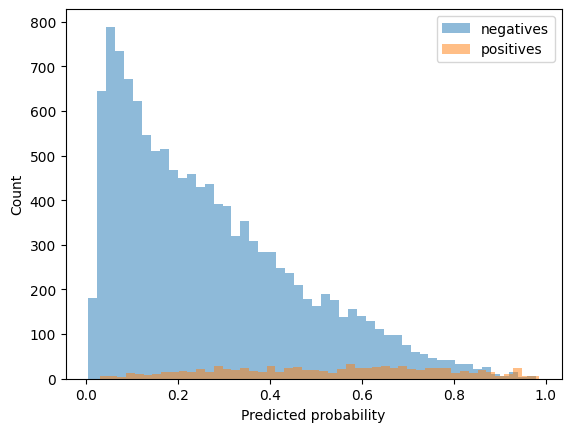

In [63]:
import matplotlib.pyplot as plt
plt.hist(val_proba[y_val==0], bins=50, alpha=0.5, label="negatives")
plt.hist(val_proba[y_val==1], bins=50, alpha=0.5, label="positives")
plt.legend(); plt.xlabel("Predicted probability"); plt.ylabel("Count");


# logisitic regression

In [ ]:
import json
import joblib
import numpy as np
import pandas as pd
from os.path import exists
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, classification_report
)

# Paths/config
results_path = "logreg_grid_results_selected_subset_features.parquet"   # where partial results are saved
best_model_path = "logreg_best_model_selected_subset_features.pkl"  
max_iter = 2000
tol = 1e-4
random_state = 42

# --- Reload results from the previous run ---
results_df = pd.read_parquet(results_path)
print(f"Loaded {len(results_df)} parameter sets from previous grid search.")

# --- Identify best params by CV PR-AUC ---
best_row = results_df.sort_values("pr_auc_mean", ascending=False).iloc[0]
best_params = json.loads(best_row["params_json"])
print("\nBest by CV PR-AUC:", best_params, f"PR-AUC={best_row['pr_auc_mean']:.4f}")

# --- Load existing model or refit on training data ---
if exists(best_model_path):
    best_lr = joblib.load(best_model_path)
    print(f"Loaded existing best model from: {best_model_path}")
else:
    # Merge params with your overrides
    model_kwargs = dict(best_params)
    model_kwargs.update(dict(max_iter=max_iter, tol=tol, random_state=random_state))
    best_lr = LogisticRegression(**model_kwargs)
    best_lr.fit(X_train, y_train)
    joblib.dump(best_lr, best_model_path)
    print(f"Trained and saved best model to: {best_model_path}")

# --- Evaluate on validation and test sets ---
val_proba  = best_lr.predict_proba(X_val)[:, 1]
test_proba = best_lr.predict_proba(X_test)[:, 1]

print(f"[VAL]  ROC AUC={roc_auc_score(y_val, val_proba):.4f} | PR AUC={average_precision_score(y_val, val_proba):.4f}")
print(f"[TEST] ROC AUC={roc_auc_score(y_test, test_proba):.4f} | PR AUC={average_precision_score(y_test, test_proba):.4f}")

# # --- Determine threshold by max F1 on validation set ---
# prec, rec, thr = precision_recall_curve(y_val, val_proba)
# f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
# t_star = float(thr[np.nanargmax(f1s)])

# val_pred  = (val_proba  >= t_star).astype(int)
# test_pred = (test_proba >= t_star).astype(int)

# print(f"\nChosen threshold (VAL, max F1): {t_star:.6f}")
# print("[VAL]  report:\n",  classification_report(y_val,  val_pred,  digits=3))
# print("[TEST] report:\n", classification_report(y_test, test_pred, digits=3))

# t95 = threshold_for_sensitivity(y_val, val_proba, target_sens=0.95)
# print(f"VAL threshold for sens>=0.95: {t95:.6f}")

# val_pred  = (val_proba  >= t95).astype(int)
# test_pred = (test_proba >= t95).astype(int)

# print("[VAL @95% sens]\n",  classification_report(y_val,  val_pred,  digits=3))
# print("[TEST @95% sens]\n", classification_report(y_test, test_pred, digits=3))

t_sens95 = threshold_for_sensitivity(y_val, val_proba, target_sens=0.95)
print(f"\nVAL threshold for sens>=0.95: {t_sens95:.6f}")

# You can add any fixed thresholds you want to compare
candidate_thresholds = [
    t_sens95 - 0.05,
    t_sens95 - 0.01,
    t_sens95,
    t_sens95 + 0.01,
    t_sens95 + 0.03,
    t_sens95 + 0.5
]

# 6) build tables for VAL and TEST
val_rows = [metrics_at_threshold(y_val, val_proba, thr) for thr in candidate_thresholds]
test_rows = [metrics_at_threshold(y_test, test_proba, thr) for thr in candidate_thresholds]

val_df = pd.DataFrame(val_rows).sort_values("threshold").reset_index(drop=True)
test_df = pd.DataFrame(test_rows).sort_values("threshold").reset_index(drop=True)

# 7) print nicely (you can to_parquet/csv later)
pd.set_option("display.precision", 4)
print("\nVAL metrics by threshold:")
print(val_df)

print("\nTEST metrics by threshold:")
print(test_df)

# 8) still show the classic sklearn report at the sens>=95% threshold
val_pred  = (val_proba  >= t_sens95).astype(int)
test_pred = (test_proba >= t_sens95).astype(int)

print("\n[VAL @95% sens]\n",  classification_report(y_val,  val_pred,  digits=3))
print("\n[TEST @95% sens]\n", classification_report(y_test, test_pred, digits=3))

Loaded 300 parameter sets from previous grid search.

Best by CV PR-AUC: {'C': 0.05, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'} PR-AUC=0.2009
Loaded existing best model from: logreg_best_model_selected_subset_features.pkl
[VAL]  ROC AUC=0.7925 | PR AUC=0.2173
[TEST] ROC AUC=0.7873 | PR AUC=0.1948

VAL threshold for sens>=0.95: 0.013291

VAL metrics by threshold:
   threshold     PPV     NPV  Sensitivity  Specificity  Prevalence  Accuracy  \
0    -0.0367  0.0437  0.0000       1.0000       0.0000      0.0437    0.0437   
1     0.0033  0.0449  0.9902       0.9927       0.0335      0.0437    0.0754   
2     0.0133  0.0548  0.9911       0.9510       0.2496      0.0437    0.2803   
3     0.0233  0.0686  0.9899       0.9019       0.4404      0.0437    0.4605   
4     0.0433  0.0955  0.9841       0.7629       0.6698      0.0437    0.6738   
5     0.5133  0.7368  0.9573       0.0254       0.9996      0.0437    0.9570   

       F1    TP     FP     TN    FN  defer_rate   miss_

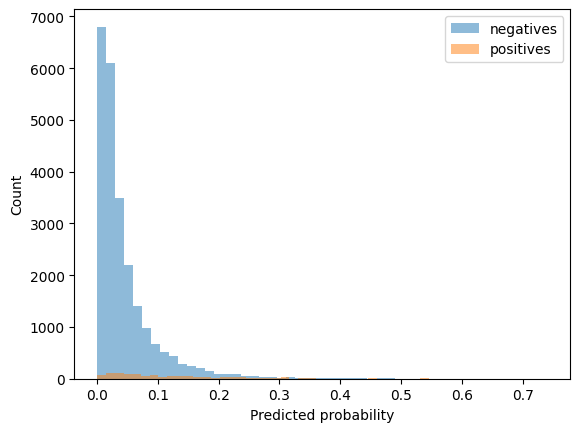

In [ ]:
import matplotlib.pyplot as plt
plt.hist(val_proba[y_val==0], bins=50, alpha=0.5, label="negatives")
plt.hist(val_proba[y_val==1], bins=50, alpha=0.5, label="positives")
plt.legend(); plt.xlabel("Predicted probability"); plt.ylabel("Count");


In [27]:
import json, time, os, hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score, roc_auc_score, precision_recall_curve, roc_curve,
    f1_score, classification_report
)

# ---------- config (quick/smoke) ----------
results_path = "logreg_quick_results_dedup_two_less_features.parquet"           # separate file for quick run
best_model_path = "logreg_best_model_quick_dedup_two_less_features.pkl"
random_state = 42
n_splits = 3                                            # faster smoke test
max_iter = 2000
tol = 1e-4
scoring = {"pr_auc": "average_precision", "roc_auc": "roc_auc"}
TARGET_RECALL = 0.95

# Tiny hand-picked grid: previous best + neighbors
quick_grid = [
    # previous best
    {"penalty": "l1", "solver": "liblinear", "C": 0.05, "class_weight": None},

    # small C sweep around 0.05 (l1 + liblinear)
    {"penalty": "l1", "solver": "liblinear", "C": 0.03, "class_weight": None},
    {"penalty": "l1", "solver": "liblinear", "C": 0.08, "class_weight": None},

    # try balanced weights with same neighborhood
    {"penalty": "l1", "solver": "liblinear", "C": 0.05, "class_weight": "balanced"},
    {"penalty": "l1", "solver": "liblinear", "C": 0.03, "class_weight": "balanced"},
    {"penalty": "l1", "solver": "liblinear", "C": 0.08, "class_weight": "balanced"},

    # try l1 + saga (can behave a bit differently on larger feature spaces)
    {"penalty": "l1", "solver": "saga", "C": 0.05, "class_weight": None},
    {"penalty": "l1", "solver": "saga", "C": 0.05, "class_weight": "balanced"},

    # try l2 neighbors for comparison
    {"penalty": "l2", "solver": "liblinear", "C": 0.05, "class_weight": None},
    {"penalty": "l2", "solver": "lbfgs",     "C": 0.05, "class_weight": None},
    {"penalty": "l2", "solver": "lbfgs",     "C": 0.05, "class_weight": "balanced"},
]

# ---------- helpers ----------
def params_fingerprint(params: dict) -> str:
    s = json.dumps(params, sort_keys=True)
    return hashlib.md5(s.encode()).hexdigest()

def load_results(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        return pd.read_parquet(path)
    cols = ["fp", "params_json", "penalty", "solver", "C", "class_weight",
            "cv_splits", "fit_time_sec",
            "pr_auc_mean", "pr_auc_std", "roc_auc_mean", "roc_auc_std"]
    return pd.DataFrame(columns=cols)

def append_result(df: pd.DataFrame, row: dict, path: str):
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    df.to_parquet(path, index=False)
    return df

def threshold_at_recall(y_true, y_score, target_recall=0.95):
    """Pick the highest threshold that still achieves recall >= target_recall."""
    fpr, tpr, thr = roc_curve(y_true, y_score)
    # tpr is recall; we want the max threshold with tpr >= target
    idx = np.where(tpr >= target_recall)[0]
    if len(idx) == 0:
        return None  # cannot reach target recall
    # pick the largest threshold among those indices (more specific)
    return float(np.max(thr[idx]))

# ---------- quick grid run ----------
results_df = load_results(results_path)
done = set(results_df["fp"]) if len(results_df) else set()

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

print(f"Quick grid size: {len(quick_grid)} | already done: {len(done)} | remaining: {len(quick_grid) - len(done)}")

for params in quick_grid:
    fp = params_fingerprint(params)
    if fp in done:
        continue

    try:
        lr = LogisticRegression(
            **params,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state,
        )
        t0 = time.time()
        cv_res = cross_validate(
            lr, X_train, y_train,
            scoring=scoring, cv=cv, n_jobs=-1, error_score=np.nan, return_train_score=False
        )
        t1 = time.time()

        row = {
            "fp": fp,
            "params_json": json.dumps(params, sort_keys=True),
            "penalty": params["penalty"],
            "solver": params["solver"],
            "C": params["C"],
            "class_weight": str(params["class_weight"]),
            "cv_splits": n_splits,
            "fit_time_sec": round(t1 - t0, 3),
            "pr_auc_mean": float(np.nanmean(cv_res["test_pr_auc"])),
            "pr_auc_std": float(np.nanstd(cv_res["test_pr_auc"])),
            "roc_auc_mean": float(np.nanmean(cv_res["test_roc_auc"])),
            "roc_auc_std": float(np.nanstd(cv_res["test_roc_auc"])),
        }
        results_df = append_result(results_df, row, results_path)
        done.add(fp)
        print(f"[{len(done)}/{len(quick_grid)}] {params} | PR-AUC={row['pr_auc_mean']:.4f} | time={row['fit_time_sec']}s")

    except Exception as e:
        row = {
            "fp": fp,
            "params_json": json.dumps(params, sort_keys=True),
            "penalty": params.get("penalty"),
            "solver": params.get("solver"),
            "C": params.get("C"),
            "class_weight": str(params.get("class_weight")),
            "cv_splits": n_splits,
            "fit_time_sec": np.nan,
            "pr_auc_mean": np.nan,
            "pr_auc_std": np.nan,
            "roc_auc_mean": np.nan,
            "roc_auc_std": np.nan,
        }
        results_df = append_result(results_df, row, results_path)
        done.add(fp)
        print(f"[{len(done)}/{len(quick_grid)}] FAILED {params} -> {e}")

# ---------- pick best by PR-AUC, refit, then threshold for 95% recall ----------
if len(results_df):
    best_row = results_df.sort_values("pr_auc_mean", ascending=False).iloc[0]
    best_params = json.loads(best_row["params_json"])
    print("\n[Quick] Best by CV PR-AUC:", best_params, f"PR-AUC={best_row['pr_auc_mean']:.4f}")

    best_lr = LogisticRegression(**best_params, max_iter=max_iter, tol=tol, random_state=random_state)
    best_lr.fit(X_train, y_train)

    # Probs
    val_proba = best_lr.predict_proba(X_val)[:, 1]
    test_proba = best_lr.predict_proba(X_test)[:, 1]

    # Choose threshold that achieves ≥95% recall on VAL (if possible)
    t_star = threshold_at_recall(y_val, val_proba, TARGET_RECALL)
    if t_star is None:
        print(f"Could not reach {TARGET_RECALL:.0%} recall on VAL. Reporting max achievable instead.")
        # fall back to the threshold that maximizes recall (i.e., min threshold)
        t_star = 0.0

    # Final reports at the chosen operating point
    val_pred  = (val_proba  >= t_star).astype(int)
    test_pred = (test_proba >= t_star).astype(int)

    print(f"[VAL] ROC AUC={roc_auc_score(y_val, val_proba):.4f} | PR AUC={average_precision_score(y_val, val_proba):.4f}")
    print(f"[TEST] ROC AUC={roc_auc_score(y_test, test_proba):.4f} | PR AUC={average_precision_score(y_test, test_proba):.4f}")
    print(f"Chosen threshold for ≥{TARGET_RECALL:.0%} recall on VAL: {t_star:.6f}")

    print("[VAL]  report @95% sens:\n", classification_report(y_val,  val_pred,  digits=3))
    print("[TEST] report @VAL-chosen threshold:\n", classification_report(y_test, test_pred, digits=3))

    # Save model
    import joblib
    joblib.dump(best_lr, best_model_path)
    print(f"Saved best model to: {best_model_path}")
else:
    print("No results collected in quick run.")


Quick grid size: 11 | already done: 0 | remaining: 11


/var/folders/d1/3gdyy98d6h1d9pxx47s40vv40000gp/T/ipykernel_9143/2029072932.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[1/11] {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.05, 'class_weight': None} | PR-AUC=0.2364 | time=7.966s
[2/11] {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.03, 'class_weight': None} | PR-AUC=0.2366 | time=3.972s
[3/11] {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.08, 'class_weight': None} | PR-AUC=0.2363 | time=5.044s
[4/11] {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.05, 'class_weight': 'balanced'} | PR-AUC=0.2247 | time=3.009s
[5/11] {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.03, 'class_weight': 'balanced'} | PR-AUC=0.2249 | time=2.933s
[6/11] {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.08, 'class_weight': 'balanced'} | PR-AUC=0.2246 | time=0.899s
[7/11] {'penalty': 'l1', 'solver': 'saga', 'C': 0.05, 'class_weight': None} | PR-AUC=0.2365 | time=25.132s
[8/11] {'penalty': 'l1', 'solver': 'saga', 'C': 0.05, 'class_weight': 'balanced'} | PR-AUC=0.2247 | time=4.106s
[9/11] {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.05, 'class_weight': None} | PR-AUC=0.2359 

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np, json, time, pandas as pd

TARGET_RECALL = 0.95
random_state = 42
n_splits = 3
max_iter = 2000
tol = 1e-4

def threshold_at_recall(y_true, y_score, target_recall=0.95):
    # Use PR curve so recall is explicit; choose highest threshold with recall>=target
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    idx = np.where(rec[:-1] >= target_recall)[0]
    if len(idx) == 0:
        return None
    return float(np.max(thr[idx]))

def fold_metrics_at_rec95(clf, X, y, n_splits=3, seed=42):
    """CV where we choose the threshold to hit 95% recall inside each fold,
    then record precision and threshold; robust to pandas or NumPy inputs."""
    # Ensure 2D X and 1D y ndarrays for safe indexing
    if isinstance(X, pd.DataFrame):
        X_arr = X.to_numpy()
    else:
        X_arr = np.asarray(X)
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_arr = np.asarray(y).ravel()
    else:
        y_arr = np.asarray(y).ravel()

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    precisions, thresholds, prs, rocs = [], [], [], []

    for tr, va in cv.split(X_arr, y_arr):
        clf.fit(X_arr[tr], y_arr[tr])

        proba = clf.predict_proba(X_arr[va])[:, 1]
        prs.append(average_precision_score(y_arr[va], proba))
        rocs.append(roc_auc_score(y_arr[va], proba))

        t_star = threshold_at_recall(y_arr[va], proba, TARGET_RECALL)
        if t_star is None:
            precisions.append(0.0)
            thresholds.append(np.nan)
        else:
            pred = (proba >= t_star).astype(int)
            tp = np.sum((pred == 1) & (y_arr[va] == 1))
            fp = np.sum((pred == 1) & (y_arr[va] == 0))
            precisions.append(tp / max(tp + fp, 1))
            thresholds.append(t_star)

    return {
        "cv_pr_auc_mean": float(np.mean(prs)),
        "cv_roc_auc_mean": float(np.mean(rocs)),
        "prec_at_rec95_mean": float(np.mean(precisions)),
        "prec_at_rec95_std": float(np.std(precisions)),
        "thr_rec95_median": float(np.nanmedian(thresholds)),
        "thr_rec95_iqr": float(np.nanpercentile(thresholds, 75) - np.nanpercentile(thresholds, 25)),
    }

def make_clf(spec):
    base = LogisticRegression(
        penalty=spec["penalty"],
        solver=spec["solver"],
        C=spec["C"],
        class_weight=spec.get("class_weight", None),
        l1_ratio=spec.get("l1_ratio", None),
        max_iter=max_iter, tol=tol, random_state=random_state
    )
    if spec.get("scale", False):
        return Pipeline([("z", StandardScaler(with_mean=False)), ("lr", base)])
    return base

# ====== Run quick comparison ======
rows = []
for spec in quick_specs:
    clf = make_clf(spec)
    t0 = time.time()
    m = fold_metrics_at_rec95(clf, X_train, y_train, n_splits=n_splits, seed=random_state)
    dt = round(time.time()-t0, 2)
    rows.append({**spec, **m, "fit_time_sec": dt})

quick_table = pd.DataFrame(rows).sort_values(
    ["cv_pr_auc_mean", "prec_at_rec95_mean"], ascending=[False, False]
)
print(quick_table[[
    "penalty","solver","C","l1_ratio","class_weight","scale",
    "cv_pr_auc_mean","prec_at_rec95_mean","prec_at_rec95_std",
    "thr_rec95_median","thr_rec95_iqr","fit_time_sec"
]])


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

      penalty     solver     C  l1_ratio   class_weight  scale  \
0          l1  liblinear  0.03       NaN           None  False   
3  elasticnet       saga  0.03       0.8           None   True   
2  elasticnet       saga  0.03       0.5           None   True   
4  elasticnet       saga  0.05       0.5           None   True   
1  elasticnet       saga  0.03       0.2           None   True   
5          l1  liblinear  0.03       NaN   {0: 1, 1: 8}  False   
7  elasticnet       saga  0.03       0.5   {0: 1, 1: 8}   True   
6          l1  liblinear  0.03       NaN  {0: 1, 1: 12}  False   

   cv_pr_auc_mean  prec_at_rec95_mean  prec_at_rec95_std  thr_rec95_median  \
0        0.236622            0.099572           0.000471          0.029973   
3        0.236281            0.099730           0.000341          0.029290   
2        0.236138            0.099799           0.000431          0.029129   
4        0.236085            0.099829           0.000426          0.028803   
1        0.2359

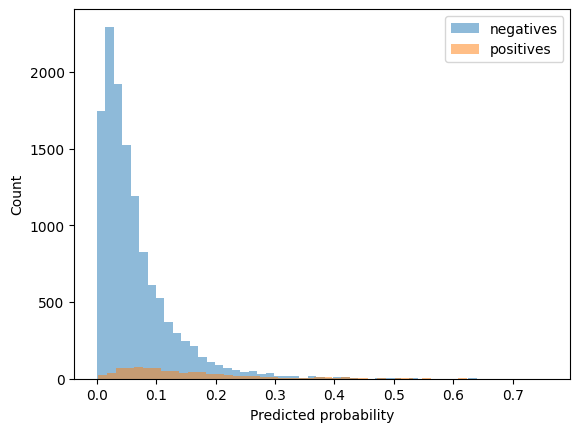

In [32]:
import matplotlib.pyplot as plt
plt.hist(val_proba[y_val==0], bins=50, alpha=0.5, label="negatives")
plt.hist(val_proba[y_val==1], bins=50, alpha=0.5, label="positives")
plt.legend(); plt.xlabel("Predicted probability"); plt.ylabel("Count");


# point system

In [33]:
# Get the coefficients
coefficients = best_lr.coef_[0]  # Coefficients for the features
intercept = best_lr.intercept_[0]  # Intercept term

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 0.11883849  0.          0.01275659  0.41725686 -0.03029448  0.12355668
 -0.10892862  0.02004506  0.46467684  0.11574386 -0.14914363  0.
 -0.2005597  -0.32998774  0.05064566  0.17237163 -0.0190347   0.
  0.          0.09249552]
Intercept: -2.815363189801397


In [29]:
import numpy as np
import pandas as pd

feature_names = X_train.columns
non_zero_indices = np.where(coefficients != 0)[0]
non_zero_features = feature_names[non_zero_indices]
non_zero_coefficients = coefficients[non_zero_indices]

# Combine into a DataFrame for sorting
coef_df = pd.DataFrame({
    "Feature": non_zero_features,
    "Coefficient": non_zero_coefficients,
    "AbsValue": np.abs(non_zero_coefficients)
})

# Sort by absolute coefficient value (descending)
coef_df = coef_df.sort_values(by="AbsValue", ascending=False)

# Print sorted results
for _, row in coef_df.iterrows():
    print(f"Feature: {row['Feature']}, Coefficient: {row['Coefficient']}")


Feature: num__max_neutrophils, Coefficient: 0.4646768407419144
Feature: num__temp_max_c, Coefficient: 0.4172568591885858
Feature: num__min_plt, Coefficient: -0.3299877437287821
Feature: num__min_hgb, Coefficient: -0.20055969654814795
Feature: num__max_lactate, Coefficient: 0.17237163255792362
Feature: num__min_lymphocytes, Coefficient: -0.14914362541393963
Feature: num__hr_max, Coefficient: 0.1235566754378744
Feature: num__age, Coefficient: 0.11883849497701655
Feature: num__max_anc, Coefficient: 0.11574386012030687
Feature: num__diabp_min, Coefficient: -0.10892861605040131
Feature: bin__has_any_line, Coefficient: 0.09249551533513638
Feature: num__max_glucose, Coefficient: 0.0506456569634074
Feature: num__resp_max, Coefficient: -0.030294478015725736
Feature: num__max_wbc, Coefficient: 0.02004505844837103
Feature: cat__gender_Female, Coefficient: -0.01903470458197416
Feature: num__adi_score, Coefficient: 0.01275659442042125


In [ ]:
# # Calculate medians for all features in your training data
# medians = X_train.median().to_dict()

# # Or if you want to be more specific and only include the features that have non-zero coefficients:
# # First get the non-zero features
# non_zero_indices = np.where(coefficients != 0)[0]
# non_zero_features = np.array(feature_names)[non_zero_indices]

# # Then calculate medians only for those features
# medians = {feature: X_train[feature].median() for feature in non_zero_features}

In [16]:
import numpy as np
import pandas as pd

def build_points_table_from_standardized(
    ct,
    X_train_base: pd.DataFrame,   # raw (pre-ColumnTransformer) TRAIN features
    feature_names: np.ndarray,    # X_train.columns (after transform)
    coefficients: np.ndarray,     # fitted coef_ aligned to X_train.columns
    scaling_factor: float = 10.0,
    rescale_coefficients_to_original_units: bool = False,
):
    """
    Create a points table with conditions in ORIGINAL units.
    Handles:
      - num: StandardScaler
      - cat: OneHotEncoder
      - bin: passthrough
    """

    # ---- 1) Pre-compute per-feature raw medians (train-only, original units)
    raw_medians = X_train_base.median(numeric_only=True).to_dict()

    # ---- 2) If wanted, convert standardized coefs -> original-unit coefs
    # For numeric columns, w_orig = w_std / std; others unchanged.
    # We need a lookup from transformed num feature -> std used by StandardScaler.
    std_lookup = {}
    # Find the StandardScaler inside the ColumnTransformer
    for name, trans, cols in ct.transformers_:
        if name == "num" and hasattr(trans, "scale_"):
            # ColumnTransformer with verbose_feature_names_out prefixes "num__"
            # and keeps column order aligned with 'cols'
            for col, std in zip(cols, trans.scale_):
                std_lookup[f"num__{col}"] = float(std)

    # Optionally rescale coefficients for numeric features
    effective_coef = []
    for fname, coef in zip(feature_names, coefficients):
        if rescale_coefficients_to_original_units and fname in std_lookup:
            std = std_lookup[fname]
            # Guard against std==0 after scaling
            coef = coef / std if std not in (0.0, None) else 0.0
        effective_coef.append(coef)
    effective_coef = np.array(effective_coef)

    # ---- 3) Build readable conditions + points
    rows = []
    for fname, coef in zip(feature_names, effective_coef):
        if coef == 0:
            continue  # skip zeros

        # NUMERIC (standardized)
        if fname.startswith("num__"):
            orig = fname.split("__", 1)[1]  # e.g., "temp_avg_c"
            med = raw_medians.get(orig, None)

            # If we don't have a median (e.g., non-numeric), skip gracefully
            if med is None or pd.isna(med):
                cond = "value present"
            else:
                # Make sign/summary-friendly thresholds
                text_thresh = f"{med:.3f}"
                # Special case: if you want different direction for min/max
                if "min" in orig:
                    cond = (f"> {text_thresh}" if coef > 0 else f"< {text_thresh}")
                    pts  = round(abs(coef) * scaling_factor)
                elif "max" in orig:
                    cond = (f"> {text_thresh}" if coef > 0 else f"< {text_thresh}")
                    pts  = round(abs(coef) * scaling_factor)
                else:
                    # avg/median/mode/other numeric
                    cond = (f"> {text_thresh}" if coef > 0 else f"< {text_thresh}")
                    pts  = round(abs(coef) * scaling_factor)

            rows.append({
                "Feature": orig,
                "Condition": cond,
                "Points": pts
            })

        # CATEGORICAL (one-hot)
        elif fname.startswith("cat__"):
            # e.g., "cat__race_White" -> col="race", level="White"
            tail = fname.split("__", 1)[1]
            if "_" in tail:
                col, level = tail.split("_", 1)
            else:
                col, level = tail, "1"

            cond = f"== {level}"
            pts  = round(coef * scaling_factor)
            rows.append({
                "Feature": f"{col}",
                "Condition": cond,
                "Points": pts
            })

        # BINARY passthrough
        elif fname.startswith("bin__"):
            orig = fname.split("__", 1)[1]
            cond = "== 1" if coef > 0 else "== 0"
            pts  = round(abs(coef) * scaling_factor)
            rows.append({
                "Feature": orig,
                "Condition": cond,
                "Points": pts
            })

        else:
            # Fallback (shouldn’t happen with the current ct)
            rows.append({
                "Feature": fname,
                "Condition": "—",
                "Points": round(coef * scaling_factor)
            })

    df = pd.DataFrame(rows)

    # ---- 4) Sort by absolute point weight (largest first)
    df["abs_points"] = df["Points"].abs()
    df = df.sort_values("abs_points", ascending=False).drop(columns=["abs_points"]).reset_index(drop=True)
    return df


In [17]:
# feature_names and coefficients should align with X_train (post-transform)
feature_names = X_train.columns.to_numpy()
coefficients = best_lr.coef_.ravel()  # or your model's coef_

df_points_table = build_points_table_from_standardized(
    ct=ct,
    X_train_base=X_train_base,                      # raw (pre-transform) training frame
    feature_names=feature_names,
    coefficients=coefficients,
    scaling_factor=10,
    rescale_coefficients_to_original_units=False    # set True if you want per *original-unit* effects
)


In [18]:
# assuming you already have `df_points_table`
df_pos = (df_points_table[df_points_table["Points"] > 0]
          .sort_values("Points", ascending=False)
          .reset_index(drop=True))

# (optional) top-k
top_k = 30
df_points_table_topk = df_pos.head(top_k)
print(df_points_table_topk)


            Feature  Condition  Points
0   max_neutrophils   > 78.200       5
1        temp_max_c   > 37.000       4
2           min_plt  < 214.000       3
3           min_hgb   < 11.500       2
4       max_lactate    > 1.500       2
5   min_lymphocytes   < 10.900       2
6           max_anc    > 7.700       1
7               age   > 65.000       1
8         sysbp_min  < 118.000       1
9            hr_max   > 99.000       1
10     has_any_line       == 1       1
11      max_glucose  > 127.000       1
12        diabp_min   < 66.000       1
13         spo2_min   > 96.000       1


In [40]:
# Keep has_any_line, drop spo2_min, apply custom thresholds to others
manual_cond = {
    "max_neutrophils": "> 70",     # 0
    "temp_max_c": "> 38",          # 1
    "min_hgb": "< 12",             # 2
    "min_plt": "< 150",            # 3
    "has_any_line": "== 1",        # 4 (explicitly keep this one)
    # skip spo2_min
    "age": "> 65",                 # 6
    "hr_max": "> 100",             # 7
    "sysbp_min": "< 90",           # 8
    "max_lactate": "> 1.5",        # 9
    "min_lymphocytes": "< 20",     # 10
    "max_glucose": "> 127",        # 11
}

# Apply manual thresholds
for feat, cond in manual_cond.items():
    df_points_table.loc[df_points_table["Feature"] == feat, "Condition"] = cond

# Remove spo2_min completely
df_points_table = df_points_table[df_points_table["Feature"] != "spo2_min"]

# Optional: only keep positive-point rules and sort
df_pos = (
    df_points_table[df_points_table["Points"] > 0]
    .sort_values("Points", ascending=False)
    .reset_index(drop=True)
)

print(df_pos)


            Feature Condition  Points
0   max_neutrophils      > 70       6
1        temp_max_c      > 38       3
2           min_hgb      < 12       2
3           min_plt     < 150       2
4      has_any_line      == 1       2
5               age      > 65       1
6            hr_max     > 100       1
7         sysbp_min      < 90       1
8       max_lactate     > 1.5       1
9   min_lymphocytes      < 20       1
10      max_glucose     > 127       1


In [19]:
import numpy as np

def make_rules_from_points_table(df_points_table):
    rules = []
    for _, row in df_points_table.iterrows():
        feature = row["Feature"]
        condition_str = str(row["Condition"]).strip()
        points = int(row["Points"])
        
        # Skip non-positive points (optional)
        if points <= 0:
            continue
        
        # Parse condition string like "> 36.8", "< 125.0", "== 1"
        if condition_str.startswith(">"):
            threshold = float(condition_str.replace(">", "").strip())
            rule = (feature, lambda x, thr=threshold: x > thr, points)
        elif condition_str.startswith("<"):
            threshold = float(condition_str.replace("<", "").strip())
            rule = (feature, lambda x, thr=threshold: x < thr, points)
        elif condition_str.startswith("=="):
            value = condition_str.replace("==", "").strip()
            # Try to cast to numeric; otherwise keep string
            try:
                val = float(value)
            except ValueError:
                val = value
            rule = (feature, lambda x, val=val: x == val, points)
        else:
            raise ValueError(f"Unsupported condition format: {condition_str}")

        rules.append(rule)
    return rules


In [20]:
def evaluate_thresholds(X, y_true, rules, thresholds):
    results = []
    X = X.copy()
    X["total_points"] = 0
    for feature, condition, pts in rules:
        if feature in X.columns:
            X["total_points"] += np.where(condition(X[feature]), pts, 0)

    for t in thresholds:
        y_pred = (X["total_points"] >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        sens = tp / (tp + fn + 1e-12)
        spec = tn / (tn + fp + 1e-12)
        ppv  = tp / (tp + fp + 1e-12)
        npv  = tn / (tn + fn + 1e-12)
        results.append((t, sens, spec, ppv, npv))
    return pd.DataFrame(results, columns=["threshold","sensitivity","specificity","PPV","NPV"])


In [21]:
rules = make_rules_from_points_table(df_points_table_topk)
# rules =  make_rules_from_points_table(df_pos)


In [24]:
thresholds = range(0, 10)  # or np.arange(0, 20, 0.5)
df_thresh = evaluate_thresholds(X_val_base, y_val, rules, thresholds)
print(df_thresh)


   threshold  sensitivity  specificity       PPV       NPV
0          0     1.000000     0.000000  0.067331  0.000000
1          1     1.000000     0.002313  0.067477  1.000000
2          2     0.997790     0.020820  0.068523  0.992395
3          3     0.992265     0.048181  0.069992  0.988543
4          4     0.990055     0.084397  0.072410  0.991565
5          5     0.982320     0.128989  0.075288  0.990202
6          6     0.976796     0.181398  0.079311  0.990850
7          7     0.970166     0.236280  0.084003  0.990967
8          8     0.955801     0.296187  0.089286  0.989342
9          9     0.939227     0.354180  0.095015  0.987764


In [50]:
thresholds = range(0, 15)  # or np.arange(0, 20, 0.5)
df_thresh = evaluate_thresholds(X_val_base, y_val, rules, thresholds)
print(df_thresh)


    threshold  sensitivity  specificity     PPV     NPV
0           0       1.0000       0.0000  0.0437  0.0000
1           1       0.9982       0.0271  0.0448  0.9969
2           2       0.9946       0.0555  0.0459  0.9955
3           3       0.9918       0.0961  0.0478  0.9961
4           4       0.9891       0.1437  0.0502  0.9965
5           5       0.9855       0.1856  0.0524  0.9964
6           6       0.9746       0.2142  0.0537  0.9946
7           7       0.9637       0.2370  0.0546  0.9930
8           8       0.9510       0.2762  0.0567  0.9919
9           9       0.9273       0.3439  0.0607  0.9904
10         10       0.8719       0.4376  0.0662  0.9868
11         11       0.7402       0.5704  0.0730  0.9796
12         12       0.6122       0.7084  0.0876  0.9756
13         13       0.4623       0.8233  0.1068  0.9710
14         14       0.3261       0.9012  0.1311  0.9669


In [25]:
best_threshold = 8  # example from validation
X_test_base_copy = X_test_base.copy()
X_test_base_copy["total_points"] = 0
for f, cond, pts in rules:
    if f in X_test_base_copy.columns:
        X_test_base_copy["total_points"] += np.where(cond(X_test_base_copy[f]), pts, 0)

y_pred_test = (X_test_base_copy["total_points"] >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
print("Test Sensitivity:", tp/(tp+fn))
print("Test Specificity:", tn/(tn+fp))
print("Test PPV:", tp/(tp+fp))
print("Test NPV:", tn/(tn+fn))

# Total number of test samples
total = tn + fp + fn + tp

# Defer rate = (TN + FN) / Total = proportion predicted negative
defer_rate = (tn + fn) / total

# Miss rate = FN / (TP + FN) = 1 - Sensitivity
miss_rate = fn / (tp + fn)

print(f"Defer rate: {defer_rate:.3f}")
print(f"Miss rate: {miss_rate:.3f}")



Test Sensitivity: 0.952513966480447
Test Specificity: 0.2748280995250585
Test PPV: 0.09090909090909091
Test NPV: 0.9870162932790224
Defer rate: 0.259
Miss rate: 0.047


In [49]:
best_threshold = 8  # example from validation
X_test_base_copy = X_test_base.copy()
X_test_base_copy["total_points"] = 0
for f, cond, pts in rules:
    if f in X_test_base_copy.columns:
        X_test_base_copy["total_points"] += np.where(cond(X_test_base_copy[f]), pts, 0)

y_pred_test = (X_test_base_copy["total_points"] >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
print("Test Sensitivity:", tp/(tp+fn))
print("Test Specificity:", tn/(tn+fp))
print("Test PPV:", tp/(tp+fp))
print("Test NPV:", tn/(tn+fn))

# Total number of test samples
total = tn + fp + fn + tp

# Defer rate = (TN + FN) / Total = proportion predicted negative
defer_rate = (tn + fn) / total

# Miss rate = FN / (TP + FN) = 1 - Sensitivity
miss_rate = fn / (tp + fn)

print(f"Defer rate: {defer_rate:.3f}")
print(f"Miss rate: {miss_rate:.3f}")



Test Sensitivity: 0.9545816733067729
Test Specificity: 0.2601457585734897
Test PPV: 0.05651743171203472
Test NPV: 0.9919593736775285
Defer rate: 0.251
Miss rate: 0.045


# SHAP for hgb

In [ ]:
import shap
import pandas as pd

explainer = shap.TreeExplainer(hgb)
shap_values = explainer.shap_values(X_train)

# mean absolute shap importance
mean_abs_shap = np.abs(shap_values).mean(axis=0)
df_shap = pd.DataFrame({
    "Feature": X_train.columns,
    "MeanAbsSHAP": mean_abs_shap
}).sort_values("MeanAbsSHAP", ascending=False)

# scale to points
df_shap["Points"] = (10 * df_shap["MeanAbsSHAP"] / df_shap["MeanAbsSHAP"].max()).round(1)
print(df_shap.head(15))


                             Feature  MeanAbsSHAP  Points
10              num__max_neutrophils       0.2725    10.0
12              num__min_lymphocytes       0.2019     7.4
22      cat__Bacteria_urine_NEGATIVE       0.1963     7.2
3                    num__temp_max_c       0.1902     7.0
18  cat__Leukocyte_Esterase_NEGATIVE       0.1663     6.1
17                  num__max_lactate       0.1609     5.9
15                      num__min_plt       0.1351     5.0
14                      num__min_hgb       0.0966     3.5
11                      num__max_anc       0.0847     3.1
9                       num__max_wbc       0.0613     2.2
16                  num__max_glucose       0.0544     2.0
13                      num__min_alc       0.0380     1.4
27                  cat__gender_Male       0.0282     1.0
8                      num__spo2_min       0.0188     0.7
6                     num__sysbp_min       0.0187     0.7


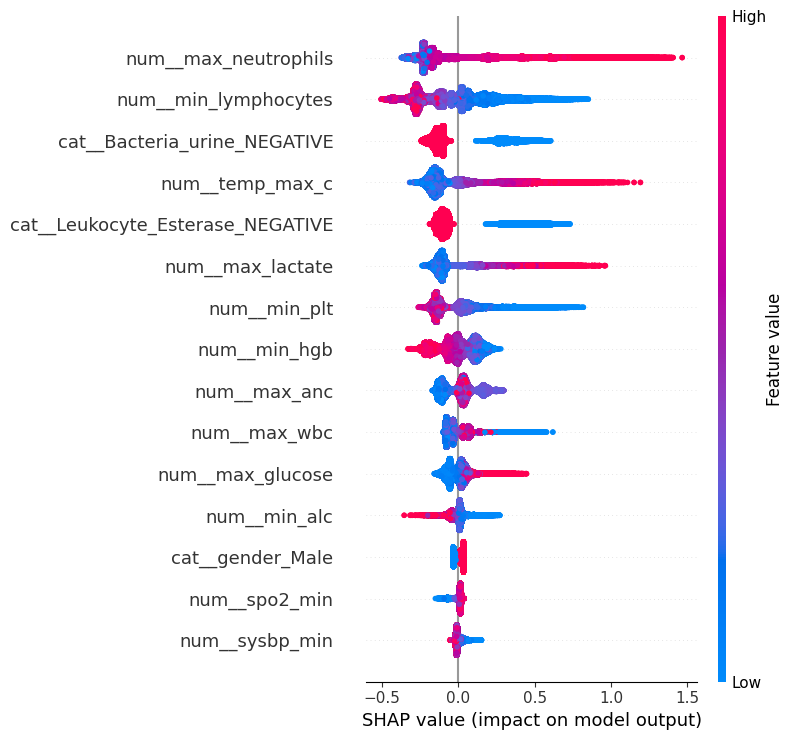

In [ ]:
shap.summary_plot(shap_values, X_train, max_display=15)


In [ ]:
import pandas as pd
import numpy as np

# shap_values: (n_samples, n_features)
# X_train: pandas DataFrame with columns matching shap_values
sv = shap_values
cols = X_train.columns

# 1) mean absolute SHAP = importance
mean_abs = np.abs(sv).mean(axis=0)

# 2) mean SHAP (with sign) = average direction
mean_signed = sv.mean(axis=0)

df_shap = pd.DataFrame({
    "Feature_raw": cols,
    "mean_abs_shap": mean_abs,
    "mean_shap": mean_signed,
})

# 3) make it prettier: strip num__/cat__/bin__
def nice_name(col):
    if col.startswith("num__"):
        return col.replace("num__", "")
    if col.startswith("cat__"):
        return col.replace("cat__", "")
    if col.startswith("bin__"):
        return col.replace("bin__", "")
    return col

df_shap["Feature"] = df_shap["Feature_raw"].apply(nice_name)

# 4) basic direction label
def direction(row):
    if row["mean_shap"] > 0:
        return "higher → higher risk"
    elif row["mean_shap"] < 0:
        return "higher → lower risk"
    else:
        return "neutral"

df_shap["Direction"] = df_shap.apply(direction, axis=1)

# 5) sort by importance
df_shap = df_shap.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

# 6) keep top N
topN = 15
df_top = df_shap.head(topN)[["Feature", "mean_abs_shap", "mean_shap", "Direction"]]
print(df_top.to_string(index=False))


                    Feature  mean_abs_shap  mean_shap            Direction
            max_neutrophils         0.2725     0.0044 higher → higher risk
            min_lymphocytes         0.2019     0.0013 higher → higher risk
    Bacteria_urine_NEGATIVE         0.1963    -0.0028  higher → lower risk
                 temp_max_c         0.1902    -0.0017  higher → lower risk
Leukocyte_Esterase_NEGATIVE         0.1663    -0.0070  higher → lower risk
                max_lactate         0.1609    -0.0017  higher → lower risk
                    min_plt         0.1351    -0.0014  higher → lower risk
                    min_hgb         0.0966     0.0013 higher → higher risk
                    max_anc         0.0847     0.0066 higher → higher risk
                    max_wbc         0.0613    -0.0050  higher → lower risk
                max_glucose         0.0544    -0.0008  higher → lower risk
                    min_alc         0.0380    -0.0004  higher → lower risk
                gender_Ma